# ARIMA-GARCH Model for TOPIX Forecasting

Name: Renyi Qu

Institution: Keio University

Date: January 14th, 2021

Supervisor: Prof. Yoann Potiron

### (1) Import packages

In [48]:
import warnings
warnings.filterwarnings('ignore')
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller
from arch import arch_model

### (2) Read data

I hesitated between using the stock price or the stock return as the time series data for this project, but the ADF test confirmed that $d=1$ is sufficient for using the stock price.

Also, open, high, and low prices are ignored. Only the close prices are used.

In [230]:
df = pd.read_csv("stock.csv",index_col="Date")[["TOPIX"]]
dates = np.array([datetime.datetime.strptime(date,"%m/%d/%Y") for date in pd.read_csv("stock.csv")["Date"].tolist()])
topix = np.array(df["TOPIX"].tolist())
display(df)

,TOPIX
Date,
11/2/2015,1526.97
11/4/2015,1540.43
11/5/2015,1555.10
11/6/2015,1563.59
11/9/2015,1590.97
...,...
12/9/2020,1779.42
12/10/2020,1776.21
12/11/2020,1782.01


In [187]:
train = np.array(df["TOPIX"].loc[:'10/30/2020'].tolist())
test = np.array(df["TOPIX"].loc['11/2/2020':].tolist())
i = np.where(dates==datetime.datetime(2020,11,2))[0][0]
train_dates = dates[:i]
test_dates = dates[i:]

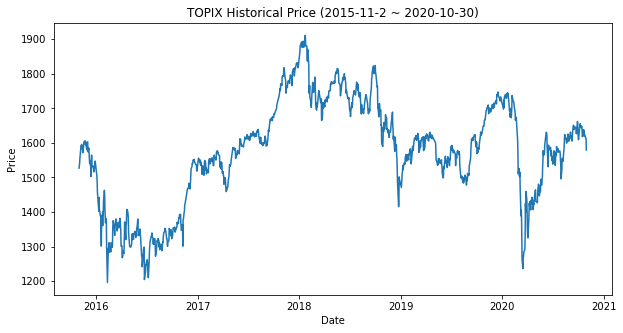

In [188]:
plt.figure(figsize=(10,5))
plt.plot(train_dates,train)
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("TOPIX Historical Price (2015-11-2 ~ 2020-10-30)")
plt.show()

This obviously does not look stationary but we will run ADF test to confirm and find the optimal differencing number.

### (3) ADF test

In [189]:
result = adfuller(train)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.090613
p-value: 0.248306


The null hypothesis is not rejected. We cannot find stationarity.

In [190]:
def difference(series):
    diff = []
    for i in range(1,len(series)):
        diff.append(series[i]-series[i-1])
    diff.append(0)
    result = adfuller(pd.Series(diff))
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    return pd.Series(diff)

In [191]:
diff = difference(train)

ADF Statistic: -34.096132
p-value: 0.000000


Text(0.5, 0, 'Date')

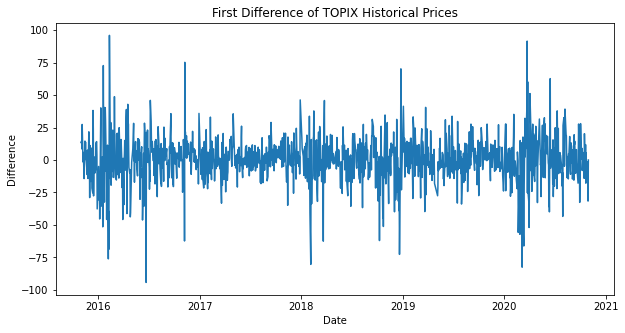

In [192]:
plt.figure(figsize=(10,5))
plt.plot(train_dates,diff)
plt.title("First Difference of TOPIX Historical Prices")
plt.ylabel("Difference")
plt.xlabel("Date")

The p-value is so small that the null hypothesis should be rejected. Differencing with degree $d=1$ leads to stationarity, and thus the order (p,1,q) is reasonable.

### (4) ACF and PACF

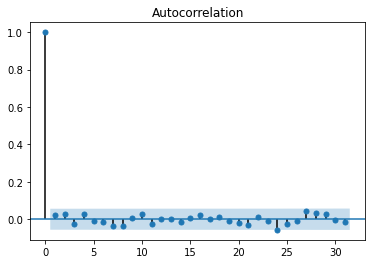

In [193]:
acf = plot_acf(diff)

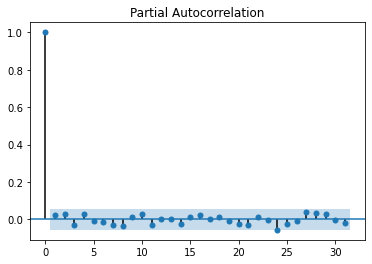

In [194]:
pacf = plot_pacf(diff)

Unfortunately, both ACF and PACF do not offer any valuable information, and therefore we cannot determine the order $p$ and $q$ from this method. This is also one key issue of stock price forecasting.

### (5) Model Selection & Fitting

In [195]:
best_arima = ARIMA(train,order=(3,1,3)).fit(method='mle',trend='nc')
print(best_arima.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 1218
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -5226.999
Method:                           mle   S.D. of innovations             17.640
Date:                Sat, 02 Jan 2021   AIC                          10467.997
Time:                        15:13:31   BIC                          10503.732
Sample:                             1   HQIC                         10481.449
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.D.y     -0.2045      0.007    -29.733      0.000      -0.218      -0.191
ar.L2.D.y      0.2048      0.009     22.034      0.000       0.187       0.223
ar.L3.D.y      0.9794      0.008    129.268      0.0

In [220]:
def best_garch(resid):
    best_bic = 99999
    for p in range(1,6):
        for q in range(1,6):
            garch = arch_model(resid,mean='Zero',p=p,q=q).fit()
            current_bic = garch.bic
            if current_bic < best_bic:
                best_bic = current_bic
                best_garch = garch
    return best_garch

In [221]:
print(best_garch(best_arima.resid).summary())

Iteration:      1,   Func. Count:      5,   Neg. LLF: 6999.051982946497
Iteration:      2,   Func. Count:     10,   Neg. LLF: 5369.720560251837
Iteration:      3,   Func. Count:     15,   Neg. LLF: 5117.464635632413
Iteration:      4,   Func. Count:     20,   Neg. LLF: 5116.5045859281345
Iteration:      5,   Func. Count:     24,   Neg. LLF: 5115.803365195679
Iteration:      6,   Func. Count:     28,   Neg. LLF: 5115.290524974025
Iteration:      7,   Func. Count:     32,   Neg. LLF: 5115.225195415543
Iteration:      8,   Func. Count:     36,   Neg. LLF: 5115.208171577964
Iteration:      9,   Func. Count:     40,   Neg. LLF: 5115.206093218085
Iteration:     10,   Func. Count:     44,   Neg. LLF: 5115.205951781398
Iteration:     11,   Func. Count:     47,   Neg. LLF: 5115.205951782361
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5115.205951781398
            Iterations: 11
            Function evaluations: 47
            Gradient evaluations: 1

Iteration:     13,   Func. Count:     98,   Neg. LLF: 5112.9206575571925
Iteration:     14,   Func. Count:    105,   Neg. LLF: 5112.920641881275
Iteration:     15,   Func. Count:    111,   Neg. LLF: 5112.920641987386
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5112.920641881275
            Iterations: 15
            Function evaluations: 111
            Gradient evaluations: 15
Iteration:      1,   Func. Count:      9,   Neg. LLF: 9374.315674596368
Iteration:      2,   Func. Count:     19,   Neg. LLF: 5632.899115169541
Iteration:      3,   Func. Count:     29,   Neg. LLF: 5301.2784800771105
Iteration:      4,   Func. Count:     39,   Neg. LLF: 5116.058053341767
Iteration:      5,   Func. Count:     48,   Neg. LLF: 5118.527685054151
Iteration:      6,   Func. Count:     57,   Neg. LLF: 5112.450447816859
Iteration:      7,   Func. Count:     65,   Neg. LLF: 5112.449244958333
Iteration:      8,   Func. Count:     74,   Neg. LLF: 5112.237395005

Iteration:     15,   Func. Count:    143,   Neg. LLF: 5112.736465429554
Iteration:     16,   Func. Count:    152,   Neg. LLF: 5112.734598852824
Iteration:     17,   Func. Count:    161,   Neg. LLF: 5112.7344420832915
Iteration:     18,   Func. Count:    170,   Neg. LLF: 5112.734439624597
Iteration:     19,   Func. Count:    178,   Neg. LLF: 5112.734439624663
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5112.734439624597
            Iterations: 19
            Function evaluations: 178
            Gradient evaluations: 19
Iteration:      1,   Func. Count:     11,   Neg. LLF: 5983.649197449755
Iteration:      2,   Func. Count:     22,   Neg. LLF: 5891.45849227136
Iteration:      3,   Func. Count:     33,   Neg. LLF: 5303.038289069007
Iteration:      4,   Func. Count:     44,   Neg. LLF: 5529.662877651861
Iteration:      5,   Func. Count:     55,   Neg. LLF: 5116.973020673985
Iteration:      6,   Func. Count:     66,   Neg. LLF: 5158.40665951298

Iteration:      5,   Func. Count:     44,   Neg. LLF: 5132.71321994827
Iteration:      6,   Func. Count:     53,   Neg. LLF: 5146.4314881640385
Iteration:      7,   Func. Count:     63,   Neg. LLF: 5117.01597900199
Iteration:      8,   Func. Count:     72,   Neg. LLF: 5116.589819351728
Iteration:      9,   Func. Count:     80,   Neg. LLF: 5116.475117578253
Iteration:     10,   Func. Count:     88,   Neg. LLF: 5116.235391495535
Iteration:     11,   Func. Count:     96,   Neg. LLF: 5115.805262424068
Iteration:     12,   Func. Count:    104,   Neg. LLF: 5115.422016771231
Iteration:     13,   Func. Count:    112,   Neg. LLF: 5115.212480753907
Iteration:     14,   Func. Count:    120,   Neg. LLF: 5115.206262762585
Iteration:     15,   Func. Count:    128,   Neg. LLF: 5115.206056171402
Iteration:     16,   Func. Count:    136,   Neg. LLF: 5115.205953243263
Iteration:     17,   Func. Count:    144,   Neg. LLF: 5115.205951676653
Iteration:     18,   Func. Count:    151,   Neg. LLF: 5115.205951

In [222]:
best_garch = arch_model(best_arima.resid,mean='Zero',p=1,q=1).fit(disp='off')

Iteration:      1,   Func. Count:      5,   Neg. LLF: 6999.051982946497
Iteration:      2,   Func. Count:     10,   Neg. LLF: 5369.720560251837
Iteration:      3,   Func. Count:     15,   Neg. LLF: 5117.464635632413
Iteration:      4,   Func. Count:     20,   Neg. LLF: 5116.5045859281345
Iteration:      5,   Func. Count:     24,   Neg. LLF: 5115.803365195679
Iteration:      6,   Func. Count:     28,   Neg. LLF: 5115.290524974025
Iteration:      7,   Func. Count:     32,   Neg. LLF: 5115.225195415543
Iteration:      8,   Func. Count:     36,   Neg. LLF: 5115.208171577964
Iteration:      9,   Func. Count:     40,   Neg. LLF: 5115.206093218085
Iteration:     10,   Func. Count:     44,   Neg. LLF: 5115.205951781398
Iteration:     11,   Func. Count:     47,   Neg. LLF: 5115.205951782361
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5115.205951781398
            Iterations: 11
            Function evaluations: 47
            Gradient evaluations: 1

In [223]:
print(best_arima.resid)

[ 13.46        14.56929556   8.56019403 ...  -5.20081947  -1.56647873
 -30.5358119 ]


### (6) Forecasting

In [238]:
mean,volatility = [],[]
test_size = 30
for i in range(test_size):
    train = topix[:-(test_size-i)]
    model_arima = ARIMA(train,order=(3,1,3)).fit(method='mle',trend='nc')
    residuals = model_arima.resid
    forecast_mean = model_arima.forecast(steps=1)[0]
    model_garch = arch_model(residuals,mean='Zero',p=1,q=1).fit(disp='off')
    forecast_volatility = np.sqrt(model_garch.forecast(horizon=1).variance.values[-1,:][0])
    mean.append(forecast_mean)
    volatility.append(forecast_volatility)

In [277]:
forecast_values = []
for i in range(30):
    value = mean[i]+np.random.normal(0,volatility[i])
    forecast_values.append(value[0])

In [279]:
err = np.mean(np.power(test-forecast_values,2))
print(err)

331.87786971538594


Text(0, 0.5, 'Price')

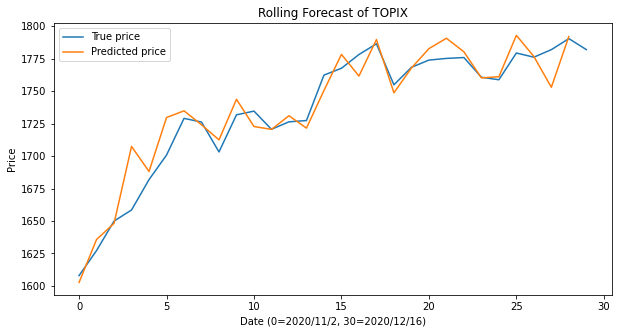

In [284]:
plt.figure(figsize=(10,5))
true, = plt.plot(test)
preds, = plt.plot(forecast_values[1:])
plt.title('Rolling Forecast of TOPIX')
plt.legend(['True price', 'Predicted price'])
plt.xlabel('Date (0=2020/11/2, 30=2020/12/16)')
plt.ylabel('Price')

### DRAFTS

In [ ]:
# # plt.figure(figsize=(40,60))
# fig, axs = plt.subplots(3, 2,figsize=(20,10))
# axs[0, 0].plot(dates,nintendo)
# axs[0, 0].set_title('NINTENDO CO., LTD.')
# axs[0, 1].plot(dates,sony,'tab:orange')
# axs[0, 1].set_title('SONY CORP.')
# axs[1, 0].plot(dates,square,'tab:green')
# axs[1, 0].set_title('SQUARE ENIX HOLDINGS CO., LTD.')
# axs[1, 1].plot(dates,sega,'tab:red')
# axs[1, 1].set_title('SEGA SAMMY HOLDINGS INC.')
# axs[2, 0].plot(dates,bandai,'tab:brown')
# axs[2, 0].set_title('BANDAI NAMCO HOLDINGS INC.')
# axs[2, 1].plot(dates,konami,'tab:purple')
# axs[2, 1].set_title('KONAMI HOLDINGS CORP.')

# for ax in axs.flat:
#     ax.set(xlabel='Date', ylabel='Price')
# for ax in axs.flat:
#     ax.label_outer()

    
# def returns(series=prices):
#     ret = []
#     for i in range(1,len(series)):
#         ret.append((series[i]-series[i-1])/series[i-1])
#     result = adfuller(pd.Series(ret))
#     print('ADF Statistic: %f' % result[0])
#     print('p-value: %f' % result[1])
#     return ret

# def best_arima(data):
#     best_aic = 99999
#     for p in range(6):
#         for q in range(6):
#             if p==0 and q==0:
#                 pass
#             else:
#                 arima = ARIMA(data,order=(p,1,q)).fit(method='mle',trend='nc')
#                 current_aic = arima.aic
#                 if current_aic < best_aic:
#                     best_aic = current_aic
#                     best_arima = arima
#     return best_arima

# def best_arima(data):
#     best_bic = 99999
#     for p in range(6):
#         for q in range(6):
#             if p==0 and q==0:
#                 pass
#             else:
#                 arima = ARIMA(data,order=(p,1,q)).fit(method='mle',trend='nc')
#                 current_bic = arima.bic
#                 if current_bic < best_bic:
#                     best_bic = current_bic
#                     best_arima = arima
#     return best_arima